# points

> binomial and poisson point process

In [ ]:
#| hide
#| default_exp points

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Literal, Optional
from fastcore.basics import patch
import functools

import numpy as np
from scipy.spatial import ConvexHull

In [ ]:
#|export

def in_hull(point:np.array,  # 1d array 
            hull:ConvexHull, # see scipy.spatial
            tol=1e-9): 
    """checks whether point is inside hull"""
    assert len(point)==hull.ndim, "expect point, hull in the same dimension"
    W,b = hull.equations[:,:-1], hull.equations[:,-1]
    return np.all(W@point+b<=tol)

In [ ]:
#|export
class Points:
    """define binomial or poisson point process in a convex polytope"""
    def __init__(self, n:int, # (expected) number of points 
                d=2,  # dimensionality
                seed: Optional[int]=None, 
                law: Literal["binomial","poisson"]="binomial", # distribution of the points 
                shape: Optional[ConvexHull]=None): # sample from shape, default to unit box
        assert law in ["binomial","poisson"]
        self.rng = np.random.default_rng(seed)
        self.n = self.rng.poisson(n) if law == "poisson" else n
        self.d = d
        self.shape = shape
    
    @functools.cached_property
    def points(self):
        """actually generate points from the prescribed distribution"""
        if self.shape is None: # unit cube
            return self.rng.uniform(size=(self.n,self.d))
        else:
            ps = []
            for _ in range(self.n):
                while True:
                    # must mint new point, no seed passed
                    sample = np.random.default_rng().uniform(self.shape.min_bound, self.shape.max_bound,(self.d,))                     
                    if in_hull(sample, self.shape): ps.append(sample); break
            assert len(ps)==self.n
            return np.array(ps)
        
    @functools.cached_property
    def distance_matrix(self):
        ps = self.points
        diff = ps[:,None,:] - ps[None,:,:]
        dm =  np.linalg.norm(diff,axis=-1)
        return dm

In [ ]:
import matplotlib.pyplot as plt

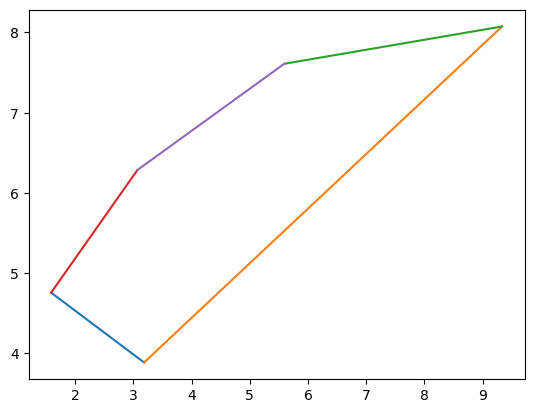

In [ ]:
rng = np.random.default_rng()
vertices = rng.uniform(0,10,size=(5,2))
hull = ConvexHull(vertices)
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

False


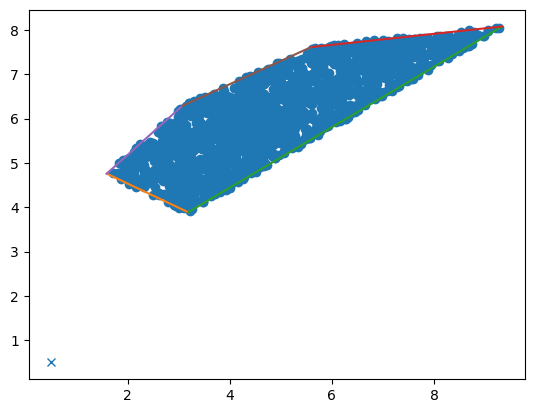

In [ ]:

process = Points(1600,shape=hull)
bin = process.points
p = np.array([0.5,0.5])
print(in_hull(p, hull))
plt.scatter(*bin.T)
plt.plot(*p, 'x')
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

In [ ]:
Points(5,d=3,shape=ConvexHull(np.random.default_rng().uniform(size=(4,3)))).points

array([[0.77855289, 0.4850915 , 0.42972623],
       [0.65133126, 0.45593755, 0.53063587],
       [0.6736211 , 0.67348507, 0.18656676],
       [0.59821495, 0.49935331, 0.47867237],
       [0.63326363, 0.58585142, 0.37836227]])

In [ ]:
#|export

@patch
def lnnl(self:Points,k:int=1):
    """computes largest k-nearest neighbour link"""
    ds = self.distance_matrix
    idx = np.argpartition(ds,k,-1)[:,k] # j-th col of argpartiion gives indices of j-th smallest of each row   
    return ds[np.arange(self.n),idx].max()

In [ ]:
process.lnnl(), process.lnnl(2), process.lnnl(3) 

(0.1465206003726509, 0.23711929766470216, 0.24755948776583622)

In [ ]:
#| export
@patch
def connectivity_threshold(self:Points, output_lnnl=False):
    s = self.rng.choice(self.n)
    component = np.zeros(self.n,dtype=bool)
    component[s]=True
    lnnl = r = self.lnnl()
    dm = self.distance_matrix
    while True:
        # collect vertices within distance r from component
        t =  np.max(dm[component]<=r,axis=0)
        if np.any(t>component): # if discover new things: add them to component
            component[t]=True
            if np.all(component): break
        else: # bfs done, component is a cluster; compute its distance to others 
            r = dm[component][:,~component].min()
    return r if not output_lnnl else (lnnl,r)

In [ ]:
process.connectivity_threshold()

0.1782874408917787

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()